####데이터 불러오기

In [ ]:
!wget https://raw.githubusercontent.com/warnikchow/3i4k/master/data/train_val_test/fci_train_val.txt
!wget https://raw.githubusercontent.com/warnikchow/3i4k/master/data/train_val_test/fci_test.txt

In [6]:
def read_data(filename):

    with open(filename, "r", encoding="UTF8") as f:
        data = [line.split("\t") for line in f.read().splitlines()]

    return data

In [7]:
train_data = read_data("/content/fci_train_val.txt")
X_train_data = [t[1] for t in train_data]
y_train_data = [int(t[0]) for t in train_data]

test_data = read_data("/content/fci_test.txt")
X_test_data = [t[1] for t in test_data]
y_test_data = [int(t[0]) for t in test_data]

In [8]:
print(len(X_train_data))
print(len(y_train_data))
print(len(X_test_data))
print(len(y_test_data))

55134
55134
6121
6121


####데이터 전처리

In [ ]:
!pip install konlpy
nltk.download('punkt')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import re
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
import nltk
from nltk.tokenize import word_tokenize

In [9]:
#훈련 데이터 카테고리 분포

label={}

for i in range(7):
    label[i]=y_train_data.count(i)

label

{0: 5409, 1: 16470, 2: 16083, 3: 11672, 4: 1571, 5: 979, 6: 2950}

In [10]:
#Augmentation
def swap(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap(new_words)
	return new_words

def EDA(sentence, alpha_rs=0.1, num_aug=4):
    words = sentence.split(' ')
    num_words = len(words)   
    augmented_sentences = []
    num_new_per_technique = int(num_aug/4) + 1
    n_rs = max(1, int(alpha_rs*num_words))

    for x in range(num_new_per_technique): 
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(" ".join(a_words))

    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    
    augmented_sentences.append(sentence)   
    return augmented_sentences
 
aug = []
for sentence in X_train_data : 
    augmented_sentences = EDA(sentence, alpha_rs = 0.1, num_aug = 4)
    aug.append(augmented_sentences)

X_train_aug = []
y_train_aug = []

for sentence in aug :  
    index = aug.index(sentence)
    for aug_sentence in sentence : 
        X_train_aug.append(aug_sentence)
        y_train_aug.append(y_train_data[index])
    
print(len(X_train_aug)) 
print(len(y_train_aug))

## result x_trian_aug 165402 
##        y_train_aug 165402

165402
165402


In [11]:
#불용어 설정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [13]:
#토큰화
from konlpy.tag import Okt
pos_tagger = Okt()

def tokenizing(doc):
    x = [t[0] for t in pos_tagger.pos(doc) if not t[0] in stopwords]
    
    return ' '.join(x)

X_train_token = [tokenizing(row) for row in X_train_aug]
X_test_token  = [tokenizing(row) for row in X_test_data]

In [47]:
print(X_train_data[0:5])
print(X_test_data[0:5])

['만화', '이치가', '약', '그사이', '짜긴']
['연두색', '되면', '오', '그걸루', '연구소']


In [20]:
from nltk.tokenize import word_tokenize
X_train_token_splitted = [nltk.word_tokenize(row) for row in X_train_token]
X_test_token_splitted  = [nltk.word_tokenize(row) for row in X_test_token]

In [21]:
tokenizer = Tokenizer(oov_token = 'OOV')
tokenizer.fit_on_texts(X_train_token_splitted)

In [25]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31437
등장 빈도가 3번 이하인 희귀 단어의 수: 16082
단어 집합에서 희귀 단어의 비율: 51.15628081559945
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.852731283248994


In [26]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 15357


In [28]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train_token_splitted)
X_train = tokenizer.texts_to_sequences(X_train_token_splitted)
X_test = tokenizer.texts_to_sequences(X_test_token_splitted)

문장의 최대 길이 : 42
문장의 평균 길이 : 6.010828164109261


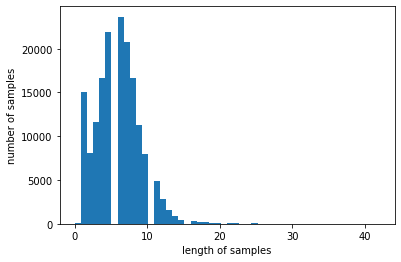

In [29]:
print('문장의 최대 길이 :',max(len(l) for l in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [70]:
max_len = 15
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.0


In [71]:
from tensorflow.keras.utils import to_categorical

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

y_train = to_categorical(y_train_aug)
y_test = to_categorical(y_test_data)

In [72]:
print(len(X_train))
print(len(y_train))

165402
165402


In [73]:
print(X_train[1000:1003])
print(X_test[1000:1003])
print(y_train[1000:1003])
print(y_test[1000:1003])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0  3915]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0  3915]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0 10618]]
[[   0    0    0    0    0    0    0    0  202   56   53 1282   74    1
   115]
 [   0    0    0    0    0    0    0    0    0    0    0    0  126 1512
    79]
 [   0    0    0    0    0    0    0  689 3503  598    4 2817   20    1
  1062]]
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


####모델링(LSTM)

In [37]:
X_train.shape

(165402, 17)

In [41]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
!pip install tensorflow-addons

from tensorflow_addons.metrics import F1Score

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [40]:
f1 = F1Score(num_classes=7, name="F1")
weighted_f1 = F1Score(num_classes=7, average="weighted", name="Weighted_F1")

In [42]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(7, activation='softmax'))

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [74]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc', f1, weighted_f1])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=512, validation_split=0.15)

Epoch 1/15
275/275 [==============================] - 55s 190ms/step - loss: 0.0565 - acc: 0.9821 - F1: 0.8221 - Weighted_F1: 0.9740 - val_loss: 5.1797 - val_acc: 0.5540 - val_F1: 0.5458 - val_Weighted_F1: 0.4382

Epoch 00001: val_acc did not improve from 0.56531
Epoch 2/15
275/275 [==============================] - 51s 185ms/step - loss: 0.0468 - acc: 0.9852 - F1: 0.8340 - Weighted_F1: 0.9852 - val_loss: 5.8906 - val_acc: 0.5522 - val_F1: 0.5357 - val_Weighted_F1: 0.4379

Epoch 00002: val_acc did not improve from 0.56531
Epoch 3/15
275/275 [==============================] - 51s 187ms/step - loss: 0.0401 - acc: 0.9873 - F1: 0.8366 - Weighted_F1: 0.9873 - val_loss: 6.1237 - val_acc: 0.5524 - val_F1: 0.5452 - val_Weighted_F1: 0.4393

Epoch 00003: val_acc did not improve from 0.56531
Epoch 4/15
275/275 [==============================] - 52s 189ms/step - loss: 0.0350 - acc: 0.9890 - F1: 0.8388 - Weighted_F1: 0.9890 - val_loss: 6.9202 - val_acc: 0.5488 - val_F1: 0.5340 - val_Weighted_F1: 0.

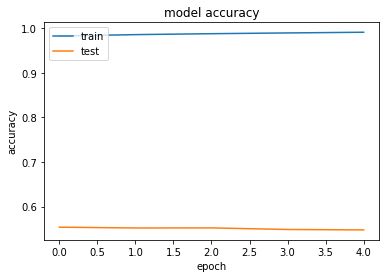

In [75]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [80]:
score=model.evaluate(X_test, y_test)
print(score)

192/192 [==============================] - 1s 8ms/step - loss: 1.8150 - acc: 0.8015 - F1: 0.6292 - Weighted_F1: 0.7801
[1.8150081634521484, 0.8015030026435852, array([0.91347754, 0.80106807, 0.8793669 , 0.8143801 , 0.41558444,
       0.5803109 , 0.        ], dtype=float32), 0.7801032662391663]


####모델링(CNN)

In [63]:
from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, GlobalMaxPooling1D

In [78]:
model_c = Sequential()
model_c.add(Embedding(vocab_size, 128, input_length=max_len))
model_c.add(Dropout(0.2))
model_c.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model_c.add(GlobalMaxPooling1D())
model_c.add(Dense(128, activation='relu'))
model_c.add(Dropout(0.2))
model_c.add(Dense(7, activation='softmax'))

In [79]:
model_c.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc', f1, weighted_f1])
history = model_c.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=512, validation_split=0.15)

Epoch 1/15
275/275 [==============================] - 40s 140ms/step - loss: 0.5896 - acc: 0.7964 - F1: 0.5898 - Weighted_F1: 0.8235 - val_loss: 3.2008 - val_acc: 0.5506 - val_F1: 0.4868 - val_Weighted_F1: 0.4298

Epoch 00001: val_acc did not improve from 0.56531
Epoch 2/15
275/275 [==============================] - 37s 136ms/step - loss: 0.1878 - acc: 0.9406 - F1: 0.7379 - Weighted_F1: 0.9391 - val_loss: 4.0065 - val_acc: 0.5582 - val_F1: 0.5452 - val_Weighted_F1: 0.4459

Epoch 00002: val_acc did not improve from 0.56531
Epoch 3/15
275/275 [==============================] - 38s 138ms/step - loss: 0.1056 - acc: 0.9671 - F1: 0.7997 - Weighted_F1: 0.9670 - val_loss: 4.6647 - val_acc: 0.5557 - val_F1: 0.5455 - val_Weighted_F1: 0.4424

Epoch 00003: val_acc did not improve from 0.56531
Epoch 4/15
275/275 [==============================] - 38s 139ms/step - loss: 0.0733 - acc: 0.9777 - F1: 0.8192 - Weighted_F1: 0.9776 - val_loss: 4.9610 - val_acc: 0.5540 - val_F1: 0.5450 - val_Weighted_F1: 0.

In [81]:
score=model_c.evaluate(X_test, y_test)
print(score)

192/192 [==============================] - 1s 4ms/step - loss: 1.3886 - acc: 0.8183 - F1: 0.6393 - Weighted_F1: 0.7946
[1.3885889053344727, 0.8183303475379944, array([0.9086337 , 0.82019573, 0.889371  , 0.83902806, 0.48148146,
       0.53608245, 0.        ], dtype=float32), 0.7945775985717773]
